<a href="https://colab.research.google.com/github/aghosh92/DCNN_MD/blob/main/Demo%20workflow/notebooks/ELIT_tutorial_partI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensemble Learning Iterative Training (ELIT)

**Notebook Preparation and models training** by Ayana Ghosh

**Molecular Dynamics (MD) Simulations** by Bobby Sumpter and Ayana Ghosh

**System**: Graphene with impurities

**STEM experiment:** by Ondrej Dyck

**Machine Learning Framework, implementation and models development** by Ayana Ghosh, Maxim Ziatdinov, Sergei V. Kalinin



---


The goal of this study is to show how the ensemble learning and iterative training (ELIT) framework can be used for iteratively adapting model(s) trained on simulated data to real-world experimental images.

0. Train ensemble of models using MD-simulated data of graphene at 300 K. No impurities or amorphous parts were present in the supercells of graphene.

1.   Apply the trained ensemble of models to experimental data and compare results between different models.

2.   The best ensemble model is then applied to an experimental graphene movie for locating atoms, with (optional) postporcessing for separating lattice and amorphous phases via Gaussian Mixture Model (GMM).

3. The new ensemble is trained using a "good" (artifact-free) portion of results from (2), which is the first *n* frames of the entire movie (*n* = 6, 21). Once trained, it is used on all the remaining frames (not used for training) to obtain accurate pixel-wise classification of the entire dataset.

4. The information about atomic positions (obtained in (3)) and the corresponding raw pixel intensities is used to creat multi-class labels (segmentation masks) and (re)train the ensemble of models on the multi-class data to categorize each pixel as belogning to lattice C atoms, impurities, or background.


---





If you would like to retrain the models (instead of using the ones provided), it may be a good idea to mount a google drive so that the models can be stored there during and at the end of training.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install AtomAI:

In [2]:
#@title Install libraries
!pip install atomai
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.4/147.4 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 KB 23.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 KB 33.1 MB/s eta 0:00:00
  Created wheel for mendeleev: filename=mendeleev-0.6.1-py2.py3-none-any.whl size=174981 sha256=c243ebca9204174e75e83aae6cef26601d01d62e15476eabb1b93f2ebc2efde0
  Stored in directory: /root/.cache/pip/wheels/8c/7c/e3/8527b988323eb2482cb927b046ae8efcf4adf49dc5a91f7f91
Successfully built mendeleev
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel fo

Import essential packages:

In [3]:
import atomai as aoi
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy as dc
import torch
from skimage import io
from sklearn.model_selection import train_test_split

from atomai.utils import (cv_thresh, find_com, get_downsample_factor,
                          get_nb_classes, img_pad, img_resize, peak_refinement,
                          set_train_rng, torch_format_image,
                          torch_format_spectra)

import time
from typing import Dict, List, Tuple, Type, Union

from skimage import data, feature, exposure
import wget

In [ ]:
#@title Link to all files
#https://www.dropbox.com/sh/k9l5qy5v6vhd6m8/AAB0IsCuGIAbQFYQS2EXzTv6a?dl=0

Load experimental data (we are going to need it many times throughout this notebook):

--2023-01-06 01:33:26--  https://www.dropbox.com/s/fy61d37f1ekpl3m/3D%20Stack8%2010nmfov.tif?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/fy61d37f1ekpl3m/3D%20Stack8%2010nmfov.tif [following]
--2023-01-06 01:33:26--  https://www.dropbox.com/s/raw/fy61d37f1ekpl3m/3D%20Stack8%2010nmfov.tif
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccf61d1da23b1d8b6c647fa45da.dl.dropboxusercontent.com/cd/0/inline/B0ABNcn2iUn2RxbkRLYNvAU0C4lvgNTKbMVs94ZDZR14rxhowt1308vWQqnPxrE3b8JeRPzAAXbrLE_3PmZHYUYm_eSRE4XFJeRXPsgJkvRvaSQU0cP__eREYVN6AHBoU2cEdcObICSTBjTDNBUzPv5chArenKKmzMqESE5LEMrMfg/file# [following]
--2023-01-06 01:33:27--  https://uccf61d1da23b1d8b6c647fa45da.dl.dropboxusercontent.com/cd/0/inline/B0ABNcn2iUn2RxbkRLYNvAU0C4lvgNTKb

(-0.5, 895.5, -0.5, 895.5)

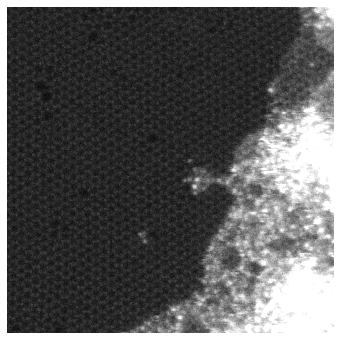

In [4]:
#@title Download image data
#Dropbox link
!wget -O 3D_Stack8_10nmfov.tif https://www.dropbox.com/s/fy61d37f1ekpl3m/3D%20Stack8%2010nmfov.tif?dl=0

filename = "3D_Stack8_10nmfov.tif"
imgdata = io.imread(filename)[:, 128:, 128:] # get rid of the "fly-back delay" part
print(imgdata.shape)

plt.figure(figsize=(6, 6))
plt.imshow(imgdata[0], origin="lower", cmap='gray', vmin=0, vmax=0.7)
plt.axis('off')

We start by training an ensemble of models from which we are going to select the basline model(s). Note that once trained, you can skip this part and focus on the iterative training part.

In [5]:
#@title Training data from MD simulations
#Dropbox link
!wget -O cropped_images_new.npy https://www.dropbox.com/s/shoskp3ff2pds0q/cropped_images_new.npy?dl=0
!wget -O cropped_masks_new.npy https://www.dropbox.com/s/j2vql6a0pd6k6lf/cropped_masks_new.npy?dl=0

--2023-01-06 01:34:02--  https://www.dropbox.com/s/shoskp3ff2pds0q/cropped_images_new.npy?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/shoskp3ff2pds0q/cropped_images_new.npy [following]
--2023-01-06 01:34:03--  https://www.dropbox.com/s/raw/shoskp3ff2pds0q/cropped_images_new.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6c9227957f1cfbc2623f666083.dl.dropboxusercontent.com/cd/0/inline/B0A7NUFFt5fcdmkaV2h8VRG6ivbzz_cme4tDmKLnXcJW5VwzwvUvSNmBd2_UUw2RpHQQeFpIfVI1bhWlDJP7Cbt1U9Fh0WCtBay9MDe3L1Os3SZGVmlBVbX1_2zJkde0-7s3gw4-9xIlpdG_mvY4NXr7KB4SciU7G6GTe_KiwFrjJQ/file# [following]
--2023-01-06 01:34:03--  https://uc6c9227957f1cfbc2623f666083.dl.dropboxusercontent.com/cd/0/inline/B0A7NUFFt5fcdmkaV2h8VRG6ivbzz_cme4tDmKLnXc

In [6]:
#link to notebook for generating training data
#https://colab.research.google.com/github/aghosh92/ELIT_tutorial/blob/main/MD_data_labelled.ipynb

In [7]:
X_train = np.load('cropped_images_new.npy')
y_train = np.load('cropped_masks_new.npy')
print(X_train.shape, y_train.shape)

(6046, 256, 256) (6046, 256, 256)


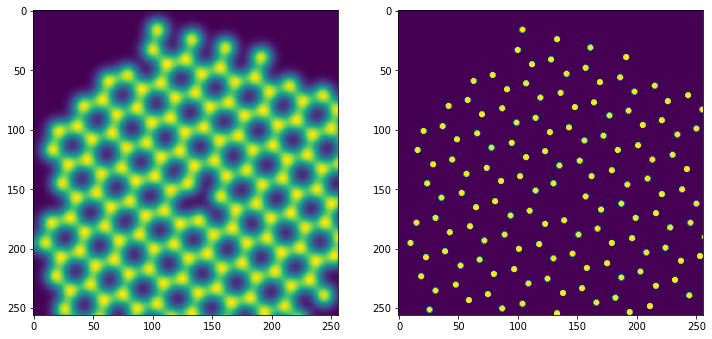

In [8]:
k = 35

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(X_train[k])
ax2.imshow(y_train[k])

Augment data so that the trained models can generalize to real experimental data:

In [9]:
dt = aoi.transforms.datatransform(1, # number of classes
                                  gauss_noise=[2000, 3000], # scaled values
                                  poisson_noise=[30, 45],
                                  blur=False,
                                  contrast=True,
                                  zoom=True,
                                  resize=[2, 1], # downsize all the images by a factor of 2
                                  seed=1)

X_train, y_train = dt.run(X_train, y_train[..., None])

Train ensemble of model starting evey time with dfifferent (randomly initialized weights)

--2023-01-06 01:41:22--  https://www.dropbox.com/s/6pivtsdu8idvyab/graphene_md_dilUnet2_ensemble.tar?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/6pivtsdu8idvyab/graphene_md_dilUnet2_ensemble.tar [following]
--2023-01-06 01:41:24--  https://www.dropbox.com/s/raw/6pivtsdu8idvyab/graphene_md_dilUnet2_ensemble.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce38a70143d01afa6035cacf852.dl.dropboxusercontent.com/cd/0/inline/B0Ddde27UpJkPfYHk-FCvHJ8vlcSHedAb2cceQHpRlJW1LhNKi8LuSTNXcmSilbig90CfPLLIxzorC9vXjZ0hhghBBUDFBf5eo6sfhKNPVdKai9ZX8_LonZ8lP4d1WpFayYx_17Liwk68Q3oCmy81JxrO9mSqQ74jC5A1_49rYpr7A/file# [following]
--2023-01-06 01:41:24--  https://uce38a70143d01afa6035cacf852.dl.dropboxusercontent.com/cd/0/inline/B0Ddde27U

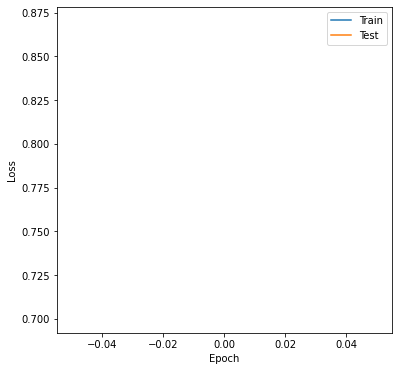


Ensemble model 2
Epoch 1/1 ... Training loss: 0.921 ... Test loss: 0.6534 ... GPU memory usage: 8324/15109
Model (final state) evaluation loss: 0.6535
Plotting training history


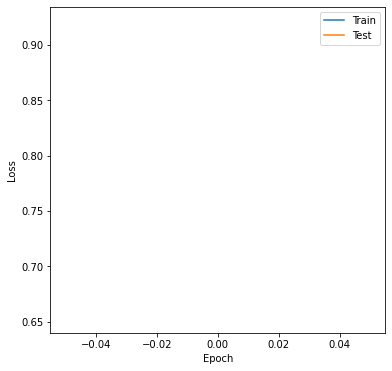


Ensemble model 3
Epoch 1/1 ... Training loss: 0.9342 ... Test loss: 0.6798 ... GPU memory usage: 8386/15109
Model (final state) evaluation loss: 0.6798
Plotting training history


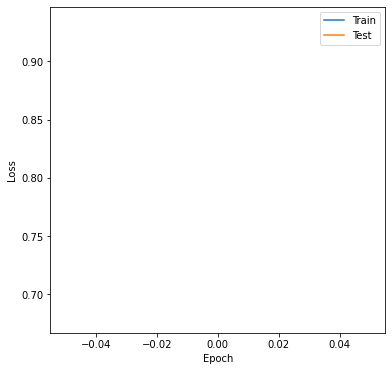


Ensemble model 4
Epoch 1/1 ... Training loss: 0.8768 ... Test loss: 0.6903 ... GPU memory usage: 8450/15109
Model (final state) evaluation loss: 0.6903
Plotting training history


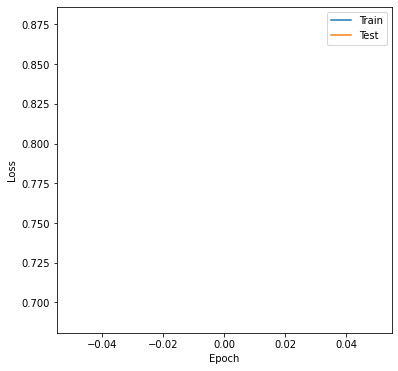


Ensemble model 5
Epoch 1/1 ... Training loss: 0.9018 ... Test loss: 0.6622 ... GPU memory usage: 8494/15109
Model (final state) evaluation loss: 0.6623
Plotting training history


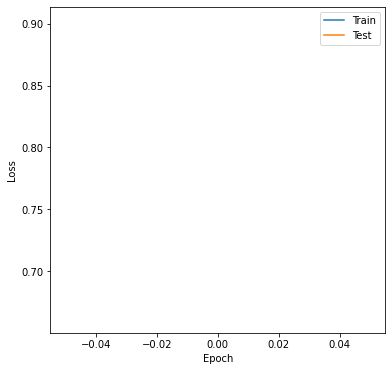


Ensemble model 6
Epoch 1/1 ... Training loss: 0.8708 ... Test loss: 0.691 ... GPU memory usage: 8558/15109
Model (final state) evaluation loss: 0.691
Plotting training history


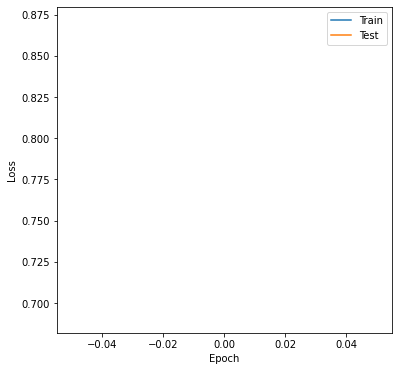


Ensemble model 7
Epoch 1/1 ... Training loss: 0.8607 ... Test loss: 0.6976 ... GPU memory usage: 8602/15109
Model (final state) evaluation loss: 0.6976
Plotting training history


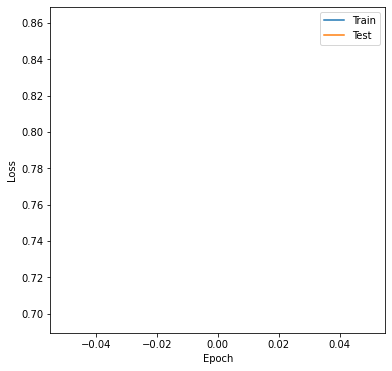


Ensemble model 8
Epoch 1/1 ... Training loss: 0.8804 ... Test loss: 0.6875 ... GPU memory usage: 8666/15109
Model (final state) evaluation loss: 0.6875
Plotting training history


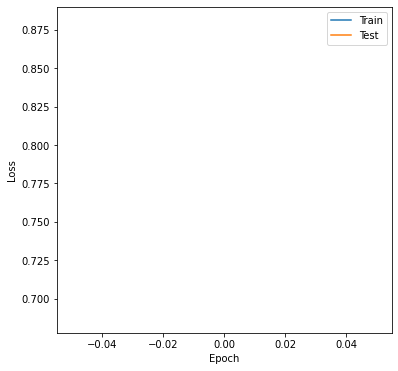


Ensemble model 9
Epoch 1/1 ... Training loss: 0.9677 ... Test loss: 0.6859 ... GPU memory usage: 8730/15109
Model (final state) evaluation loss: 0.686
Plotting training history


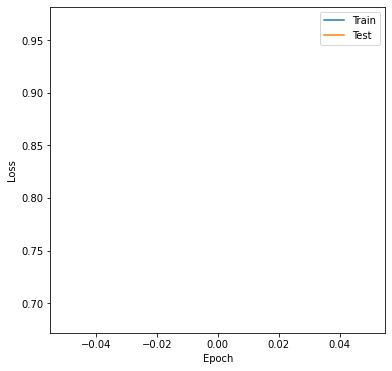


Ensemble model 10
Epoch 1/1 ... Training loss: 0.855 ... Test loss: 0.6727 ... GPU memory usage: 8774/15109
Model (final state) evaluation loss: 0.6727
Plotting training history


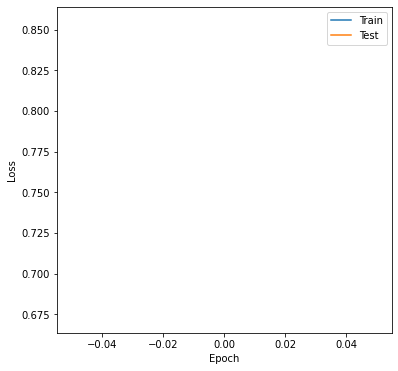


Ensemble model 11
Epoch 1/1 ... Training loss: 0.9067 ... Test loss: 0.6567 ... GPU memory usage: 8838/15109
Model (final state) evaluation loss: 0.6569
Plotting training history


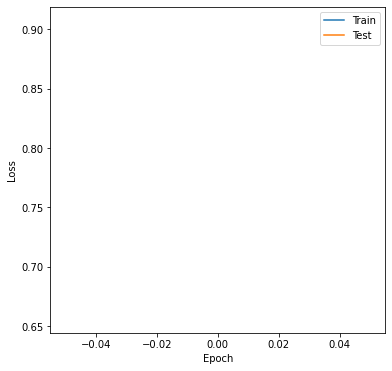


Ensemble model 12
Epoch 1/1 ... Training loss: 0.8809 ... Test loss: 0.6901 ... GPU memory usage: 8882/15109
Model (final state) evaluation loss: 0.6901
Plotting training history


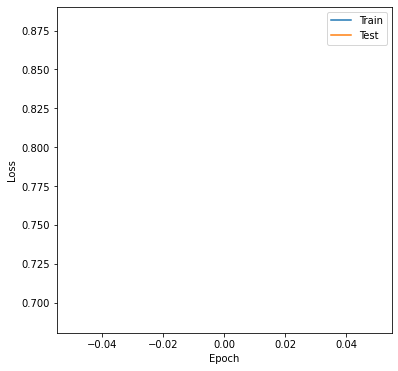


Ensemble model 13
Epoch 1/1 ... Training loss: 0.8856 ... Test loss: 0.6851 ... GPU memory usage: 8946/15109
Model (final state) evaluation loss: 0.6852
Plotting training history


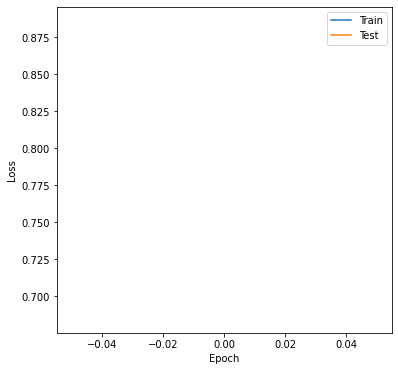


Ensemble model 14
Epoch 1/1 ... Training loss: 0.8958 ... Test loss: 0.6783 ... GPU memory usage: 8990/15109
Model (final state) evaluation loss: 0.6784
Plotting training history


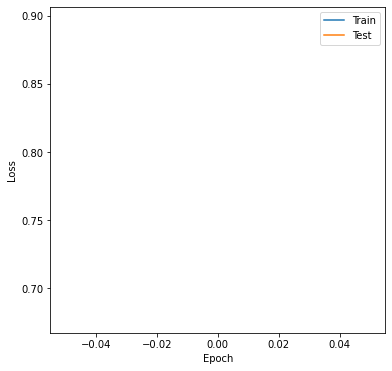


Ensemble model 15
Epoch 1/1 ... Training loss: 0.8319 ... Test loss: 0.6784 ... GPU memory usage: 9052/15109
Model (final state) evaluation loss: 0.6784
Plotting training history


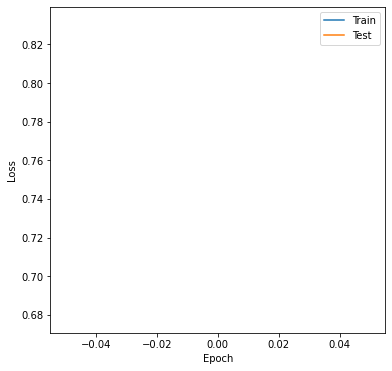


Ensemble model 16
Epoch 1/1 ... Training loss: 0.8516 ... Test loss: 0.6665 ... GPU memory usage: 9096/15109
Model (final state) evaluation loss: 0.6667
Plotting training history


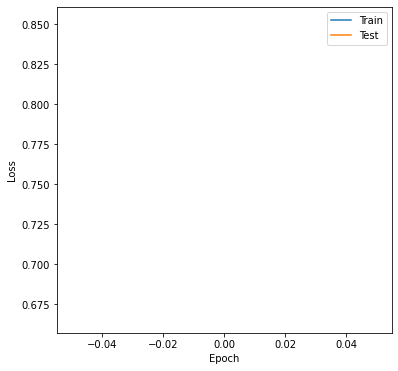


Ensemble model 17
Epoch 1/1 ... Training loss: 0.9364 ... Test loss: 0.6608 ... GPU memory usage: 9160/15109
Model (final state) evaluation loss: 0.6609
Plotting training history


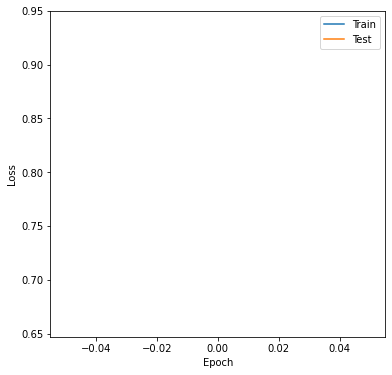


Ensemble model 18
Epoch 1/1 ... Training loss: 0.8505 ... Test loss: 0.679 ... GPU memory usage: 9204/15109
Model (final state) evaluation loss: 0.679
Plotting training history


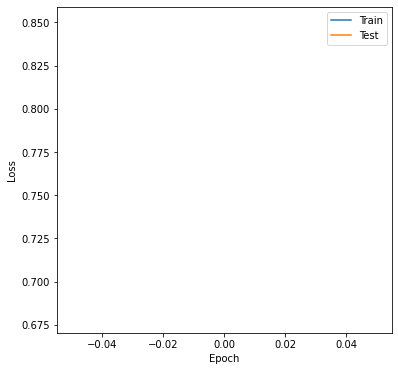


Ensemble model 19
Epoch 1/1 ... Training loss: 0.9833 ... Test loss: 0.6562 ... GPU memory usage: 9268/15109
Model (final state) evaluation loss: 0.6563
Plotting training history


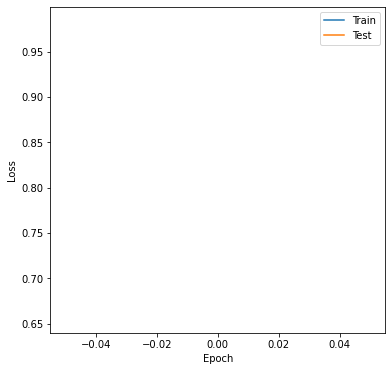


Ensemble model 20
Epoch 1/1 ... Training loss: 0.9568 ... Test loss: 0.6778 ... GPU memory usage: 9312/15109
Model (final state) evaluation loss: 0.6779
Plotting training history


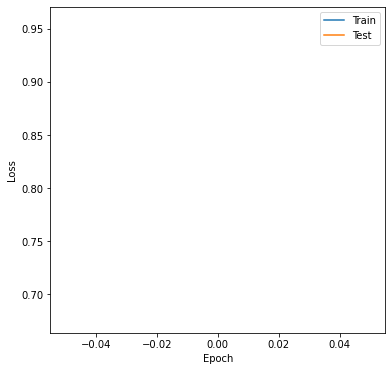

In [10]:
train_new = False

if train_new:
  etrainer = aoi.trainers.EnsembleTrainer("Unet", nb_classes=1, with_dilation=False,
                                      batch_norm=True, nb_filters=64, layers=[2, 3, 3, 4])
  etrainer.compile_ensemble_trainer(training_cycles=2000,compute_accuracy=True, swa=True, memory_alloc=0.5)
  smodel, ensemble = etrainer.train_ensemble_from_scratch(X_train, y_train, n_models=20)

else:
  !wget -O graphene_md_dilUnet2_ensemble.tar https://www.dropbox.com/s/6pivtsdu8idvyab/graphene_md_dilUnet2_ensemble.tar?dl=0
  
  #Adapt to the Atom AI new version

  # Initalize ensemble trainer and do a "fake" training for just 1 iteration using the newest atomai version

  etrainer = aoi.trainers.EnsembleTrainer("Unet", nb_classes=1, with_dilation=False,
                                          batch_norm=True, nb_filters=64, layers=[2, 3, 3, 4])

  etrainer.compile_ensemble_trainer(training_cycles=1)

  smodel, ensemble = etrainer.train_ensemble_from_scratch(X_train, y_train, n_models=20, filename="/content/new")


  # Load weights from the old model and put into the new ensemble format

  ensemble_old = torch.load("graphene_md_dilUnet2_ensemble.tar")["weights"]

  for i in range(len(ensemble)):
      ensemble[i] = ensemble_old[i]

  etrainer.save_ensemble_metadict()

  # load back the ensemble with new weigths:
  smodel, ensemble = aoi.models.load_ensemble("/content/new_ensemble_metadict.tar")

Apply each model from ensemble trained on simulated data to the real experimental data data:

Batch 1/1

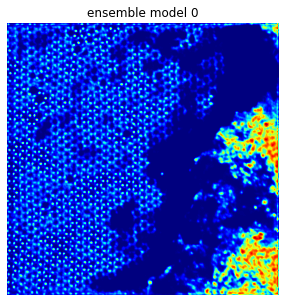

Batch 1/1

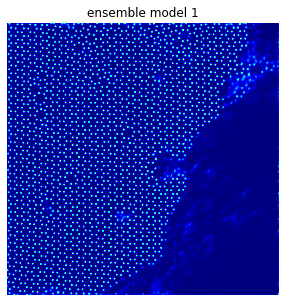

Batch 1/1

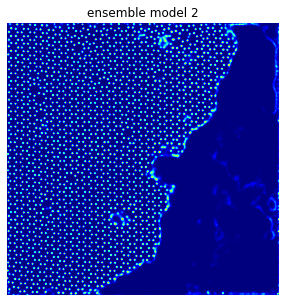

Batch 1/1

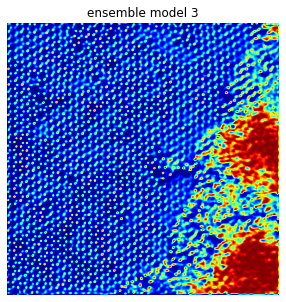

Batch 1/1

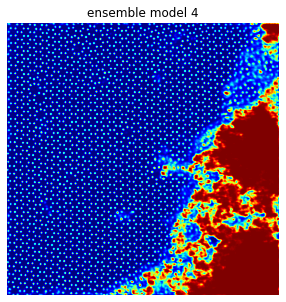

Batch 1/1

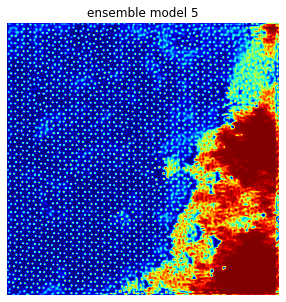

Batch 1/1

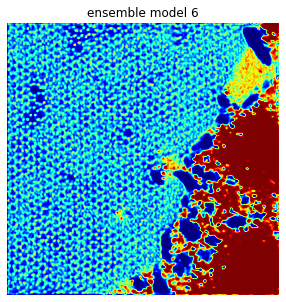

Batch 1/1

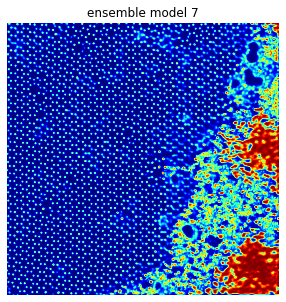

Batch 1/1

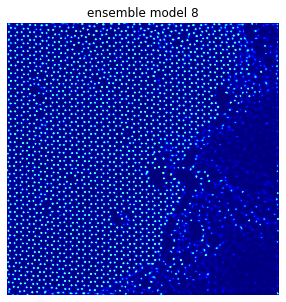

Batch 1/1

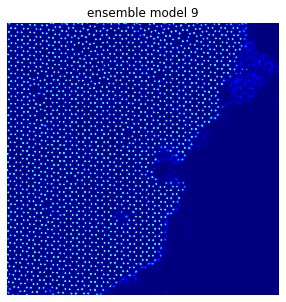

Batch 1/1

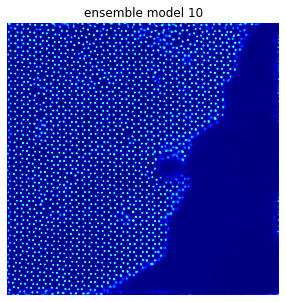

Batch 1/1

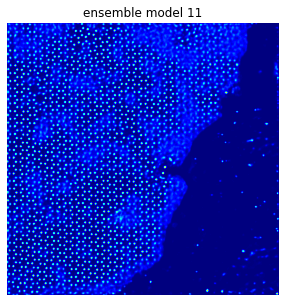

Batch 1/1

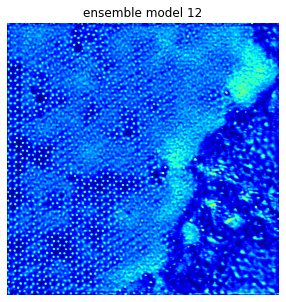

Batch 1/1

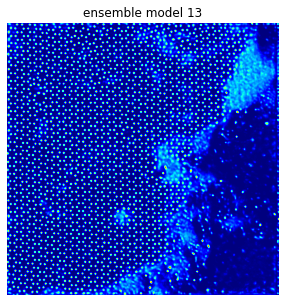

Batch 1/1

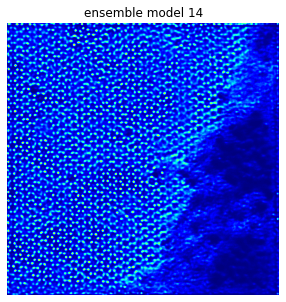

Batch 1/1

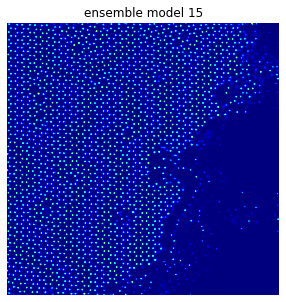

Batch 1/1

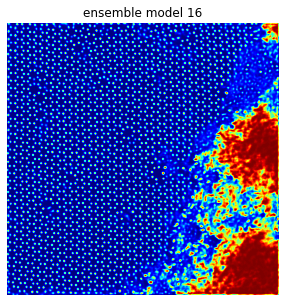

Batch 1/1

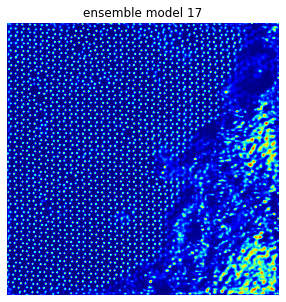

Batch 1/1

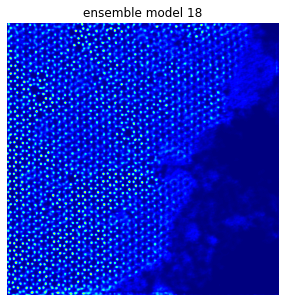

Batch 1/1

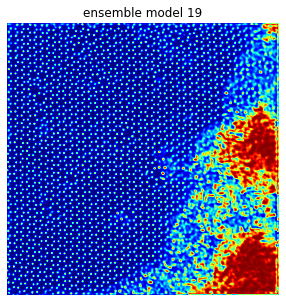

In [11]:
for i, m in enumerate(ensemble.values()):
    smodel.load_state_dict(m)
    p = aoi.predictors.SegPredictor(smodel, use_gpu=True)
    nn_out = p.predict(imgdata[0])
    plt.figure(figsize=(5, 5))
    plt.imshow(nn_out[0,...,0], origin="lower", cmap='jet', interpolation="Gaussian")
    plt.title("ensemble model {}".format(i))
    plt.axis('off')
    plt.show()

Choose and load the best ensemble model.

Here, ensemble model 19 is chosen here for the subsequent analyses.

In [12]:
smodel.load_state_dict(ensemble[19])

<All keys matched successfully>

In [13]:
decoded_imgs, coordinates = aoi.predictors.SegPredictor(smodel, use_gpu=True).run(imgdata)

Batch 100/100
100 images were decoded in approximately 43.24 seconds


View predictions on selected frames:

Text(0.5, 1.0, 'Frame 90')

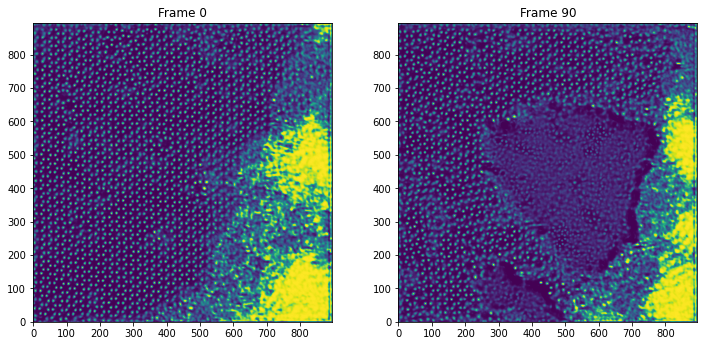

In [14]:
k1, k2 = 0, 90 # frame at the beginning and at the end of STEM movie
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5.5))
ax1.imshow(decoded_imgs[0,...,0], origin="lower")
ax1.set_title("Frame {}".format(k1))
ax2.imshow(decoded_imgs[90,...,0], origin="lower")
ax2.set_title("Frame {}".format(k2))

This function separates into 2 classes (lattice & amorphous) using GMM:

In [15]:
def gmm_classify(coord_dict_pred):
  coordinates = aoi.stat.update_classes(coord_dict_pred, imgdata, method="gmm_local",
    n_components=2, window_size=48, coord_class=0) # other methods: kmeans, meanshift, threshold
  return coordinates

Here we use GMM classification to separate amorphous part from the lattice. Hence, before using the GMM classification, it is important to check if there is both lattice & amorphous phase shown by the ensemble model. 

As an example, ensemble model 19 shows both lattice and amorphous phase in the initial prediction. Therefore, the user has chosen 'Y' (yes) for this optional step.

Can you see both lattice & amorphous phase generated by the model you just loaded ? Y or N   
Y
  

Your answer is: Y
Please execute the following steps before moving on to Iterative Training 00 cell.

GMM components


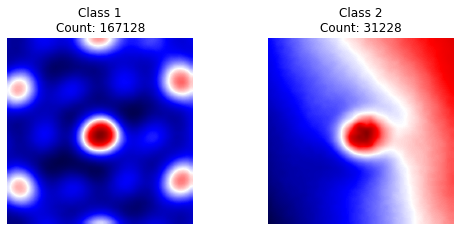

In [16]:
text = input('Can you see both lattice & amorphous phase generated by the model you just loaded ? Y or N   \n')
print("  \n")
print("Your answer is:",text)
if text == 'Y':
  print('Please execute the following steps before moving on to Iterative Training 00 cell.')
  #gmm classification
  coordinates = gmm_classify(coordinates)
else:
  print('Please skip the following steps and jump to cell named Iterative Training 00 cell.')

Here one component clearly corresponds to the amorphous phase and another one to the lattice.

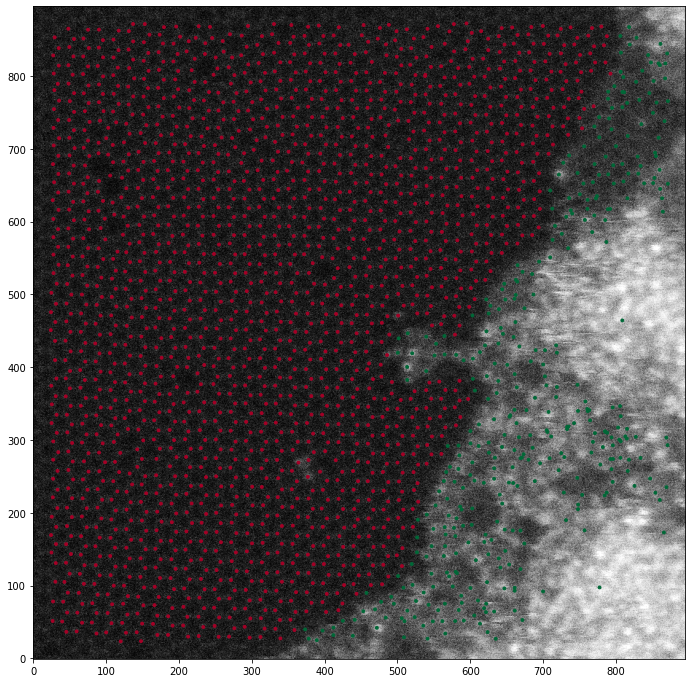

In [17]:
# Plot results
k = 0 # frame number
aoi.utils.plot_coord(imgdata[k, ...], coordinates[k], fsize=12)

Now let's filter out the coordinates corresponding to the amorphous phase:

In [18]:
coordinates_filtered = {}
for k, c in coordinates.items():
    coordinates_filtered[k] = c[c[:, -1] == 0] # adjust the "amorphous phase" class (0 or 1) if necessary

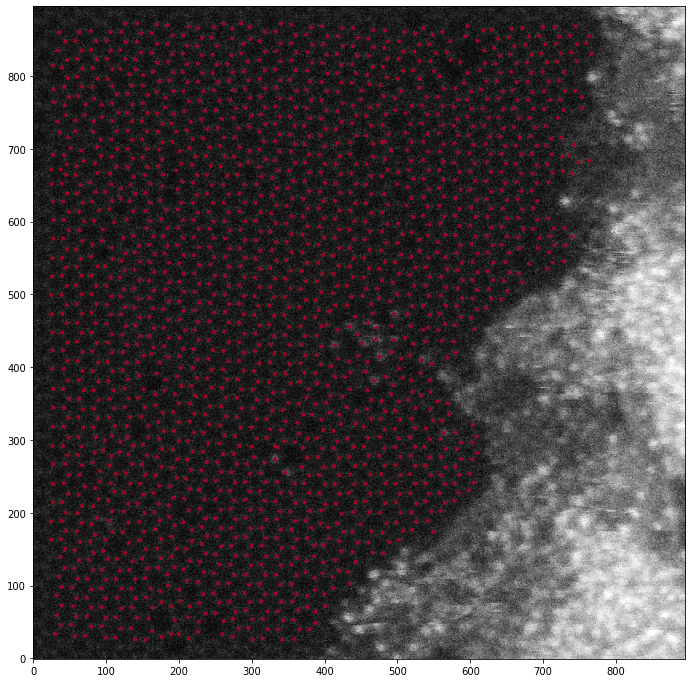

In [19]:
# Plot results
k = 20 # frame number
aoi.utils.plot_coord(imgdata[k, ...], coordinates_filtered[k], fsize=12)

### Iterative training 00: Adapting to experimental data

Now let's train a more narrowly-focused NN using the previous NN as a baseline. First we need to create a new training set. this time from the experimental data. Here we will use the same idea as in our [earlier work](https://www.nature.com/articles/s41524-019-0152-9) that for the movies of atomic transformations it is sufficient to train NN only on the first several frames where the positions are well defined (low degree of disorder) and we can easily label them.

Create ground truth for iterative training:

In [20]:
masks = np.zeros((21, *imgdata.shape[1:]))
for i in range(21):
    masks[i] = aoi.utils.create_lattice_mask(imgdata[i], coordinates_filtered[i][:, :-1])

In [21]:
X_train, y_train = aoi.utils.extract_patches(imgdata[:21], masks, patch_size=224, num_patches=200)
print(X_train.shape, y_train.shape)

(4200, 224, 224) (4200, 224, 224)


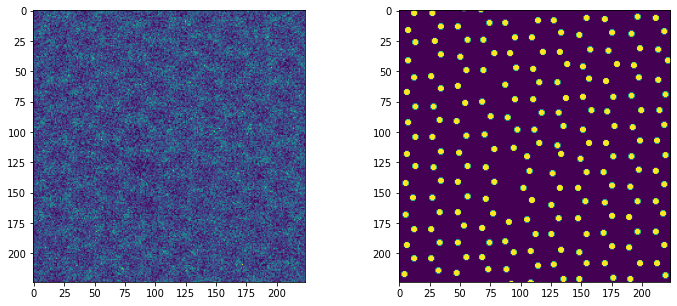

In [22]:
k = 600
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(X_train[k])
ax2.imshow(y_train[k])

In [23]:
add_noise = True

if add_noise:

    dt = aoi.transforms.datatransform(1, # number of classes
                                    gauss_noise=[0, 100], # scaled values
                                    #contrast=True,
                                    zoom=1.1,
                                    rotation=True,
                                    seed=1)

    X_train, y_train = dt.run(X_train, y_train[..., None])

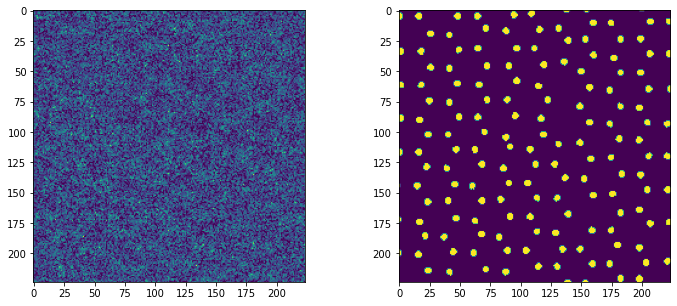

In [24]:
if add_noise:
    k = 600
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.imshow(X_train[k, 0])
    ax2.imshow(y_train[k,0])

In [25]:
#show model architecture. 
#Note that the architecture of this model should be identical to the model to be trained in the next cell 
#to ensure appropriate use of 'baseline approach'.
smodel

Unet(
  (c1): ConvBlock(
    (block): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.01)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (c2): ConvBlock(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.01)
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Conv2d(128, 128, kernel_size=(3, 3), stri

Train a new ensemble from scratch using experimental images as training data:

--2023-01-06 01:50:43--  https://www.dropbox.com/s/zre6pkied3sxpr3/graphene_elit_00_2b_ensemble.tar?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/zre6pkied3sxpr3/graphene_elit_00_2b_ensemble.tar [following]
--2023-01-06 01:50:44--  https://www.dropbox.com/s/raw/zre6pkied3sxpr3/graphene_elit_00_2b_ensemble.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc18228d05b96dd53ac66e8f61c1.dl.dropboxusercontent.com/cd/0/inline/B0ARwAu7JfxvQcxS4LDDJe920CRNXbCpr85-WdthR6DOHRJmlZ1XUfHy2zO2LvU3LeeI4To4WdqBTafDt4Zn9TyV_KzOk_P-JMS6cCNj47sHwJ-6nfrYOViFzzdw-PyBNznvtgijuMgQFu0aaPe4Dmr63VSg5EAbfyy03NOakhx51A/file# [following]
--2023-01-06 01:50:45--  https://uc18228d05b96dd53ac66e8f61c1.dl.dropboxusercontent.com/cd/0/inline/B0ARwAu7Jfxv

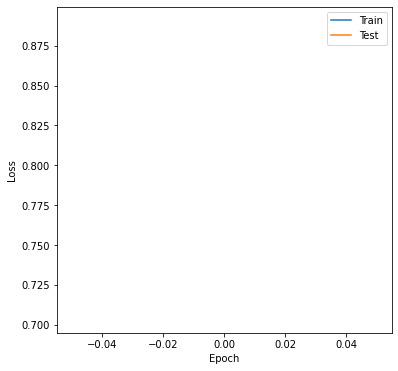


Ensemble model 2
Epoch 1/1 ... Training loss: 0.8927 ... Test loss: 0.6789 ... GPU memory usage: 13486/15109
Model (final state) evaluation loss: 0.6796
Plotting training history


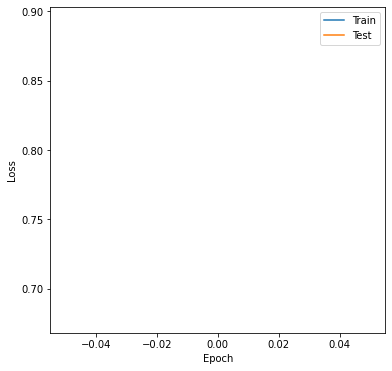


Ensemble model 3
Epoch 1/1 ... Training loss: 0.9928 ... Test loss: 0.6678 ... GPU memory usage: 13470/15109
Model (final state) evaluation loss: 0.6664
Plotting training history


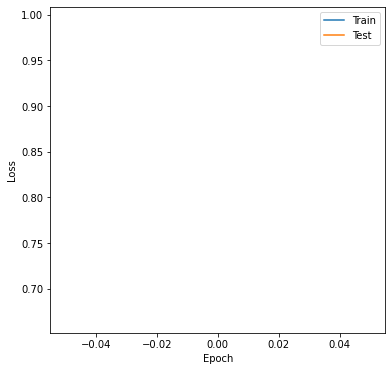


Ensemble model 4
Epoch 1/1 ... Training loss: 0.8918 ... Test loss: 0.6838 ... GPU memory usage: 13486/15109
Model (final state) evaluation loss: 0.683
Plotting training history


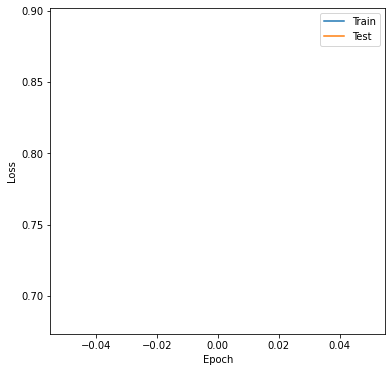


Ensemble model 5
Epoch 1/1 ... Training loss: 0.882 ... Test loss: 0.6783 ... GPU memory usage: 13470/15109
Model (final state) evaluation loss: 0.679
Plotting training history


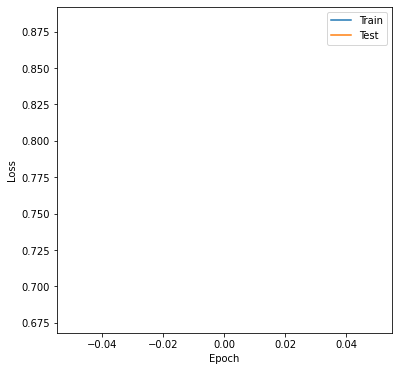


Ensemble model 6
Epoch 1/1 ... Training loss: 0.8814 ... Test loss: 0.7056 ... GPU memory usage: 13486/15109
Model (final state) evaluation loss: 0.7047
Plotting training history


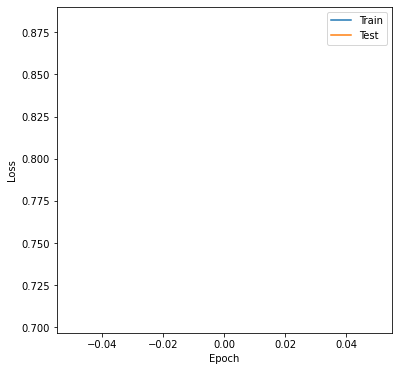

In [26]:
train_new = False

if train_new:
  etrainer = aoi.trainers.EnsembleTrainer("Unet", nb_classes=1, with_dilation=False,
                                      batch_norm=True, nb_filters=64, layers=[2, 3, 3, 4])
  etrainer.compile_ensemble_trainer(training_cycles=2000,compute_accuracy=True, swa=True, memory_alloc=0.5)
  smodel, ensemble = etrainer.train_ensemble_from_scratch(X_train, y_train, n_models=6)

else:
  
  !wget -O graphene_elit_00_2b_ensemble.tar https://www.dropbox.com/s/zre6pkied3sxpr3/graphene_elit_00_2b_ensemble.tar?dl=0
  
  #Adapt to the Atom AI new version

  # Initalize ensemble trainer and do a "fake" training for just 1 iteration using the newest atomai version

  etrainer = aoi.trainers.EnsembleTrainer("Unet", nb_classes=1, with_dilation=False,
                                        batch_norm=True, nb_filters=64, layers=[2, 3, 3, 4])

  etrainer.compile_ensemble_trainer(training_cycles=1,batch_size=12)

  smodel, ensemble = etrainer.train_ensemble_from_scratch(X_train, y_train, n_models=6, filename="/content/new0")


  # Load weights from the old model and put into the new ensemble format

  ensemble_old = torch.load("graphene_elit_00_2b_ensemble.tar")["weights"]

  for i in range(len(ensemble)):
      ensemble[i] = ensemble_old[i]

  etrainer.save_ensemble_metadict()

  # load back the ensemble with new weigths:
  smodel_00, ensemble_00 = aoi.models.load_ensemble("/content/new0_ensemble_metadict.tar")

Prediction with the re-trained ensemble:

In [27]:
# Initialize predictor
p = aoi.predictors.EnsemblePredictor(smodel_00,ensemble_00,nb_classes=1)

Batch 1/1

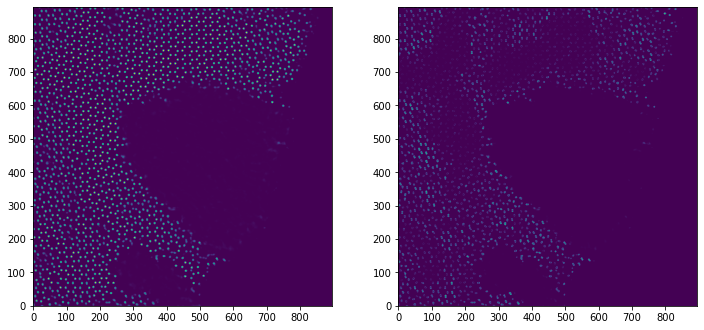

In [28]:
# prediction with uncertainty on individual frame
k = 90

img_mean, img_var = p.predict(imgdata[k:k+1])
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5.5))
ax1.imshow(img_mean[0,...,0], origin="lower")
ax2.imshow(img_var[0,...,0], origin="lower")

Make a prediction on the entire set using the ensemble trained from baseline:

In [29]:
decoded_imgs_all = []
decoded_var_all = []

for i in range(imgdata.shape[0]):
  decode_img_loc, decode_var_loc = p.predict(imgdata[i:i+1])
  decoded_imgs_all.append(decode_img_loc)
  decoded_var_all.append(decode_var_loc)
  torch.cuda.empty_cache()

Batch 1/1

In [30]:
len(decoded_imgs_all)

100

In [31]:
decoded_imgs_all = np.array(decoded_imgs_all)
decoded_imgs_all = np.reshape(decoded_imgs_all,(100,896,896,1))
decoded_var_all = np.array(decoded_var_all)

In [32]:
Locator = aoi.predictors.predictor.Locator

In [33]:
coordinates = Locator(threshold = 0.33).run(decoded_imgs_all)

View results for selected frames:

Text(0.5, 1.0, 'Original Frame 0')

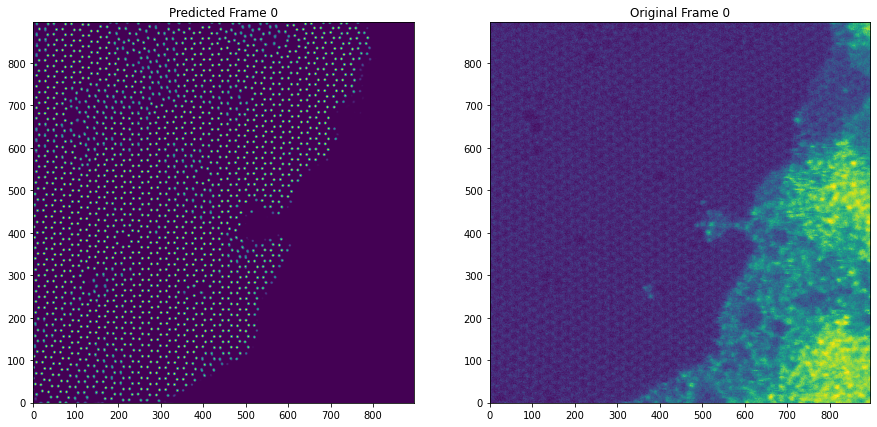

In [34]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.imshow(decoded_imgs_all[0,...,0], origin="lower")
ax1.set_title('Predicted Frame 0')
ax2.imshow(imgdata[0,...], origin="lower")
ax2.set_title('Original Frame 0')

Text(0.5, 1.0, 'Original Frame 0')

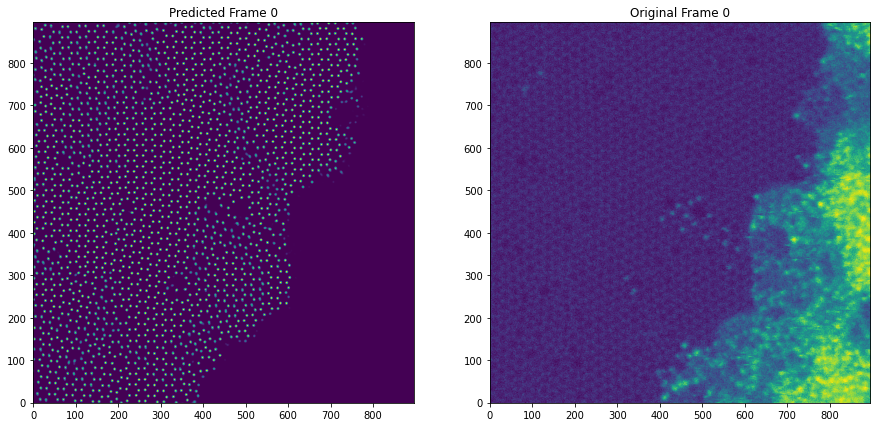

In [35]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.imshow(decoded_imgs_all[25,...,0], origin="lower")
ax1.set_title('Predicted Frame 0')
ax2.imshow(imgdata[25,...], origin="lower")
ax2.set_title('Original Frame 0')

Text(0.5, 1.0, 'Original Frame 0')

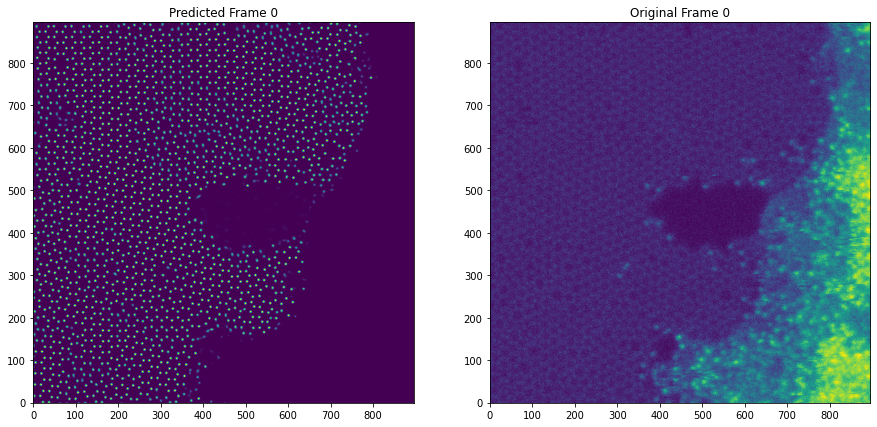

In [36]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.imshow(decoded_imgs_all[50,...,0], origin="lower")
ax1.set_title('Predicted Frame 0')
ax2.imshow(imgdata[50,...], origin="lower")
ax2.set_title('Original Frame 0')

Text(0.5, 1.0, 'Original Frame 0')

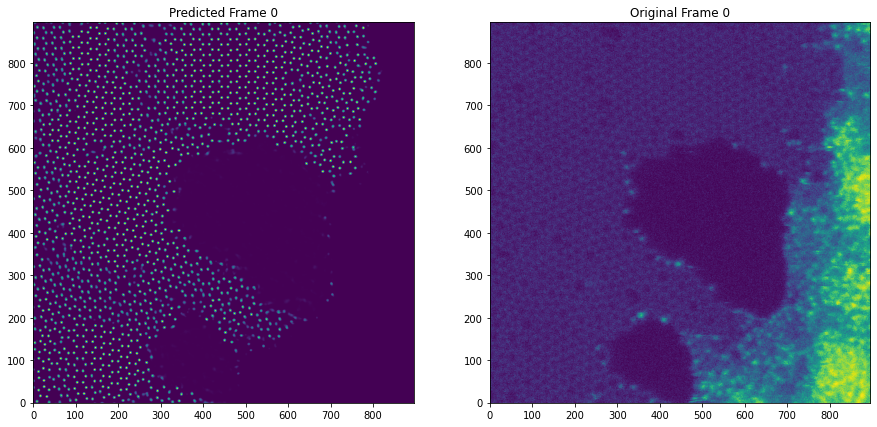

In [37]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.imshow(decoded_imgs_all[75,...,0], origin="lower")
ax1.set_title('Predicted Frame 0')
ax2.imshow(imgdata[75,...], origin="lower")
ax2.set_title('Original Frame 0')

Text(0.5, 1.0, 'Original Frame 0')

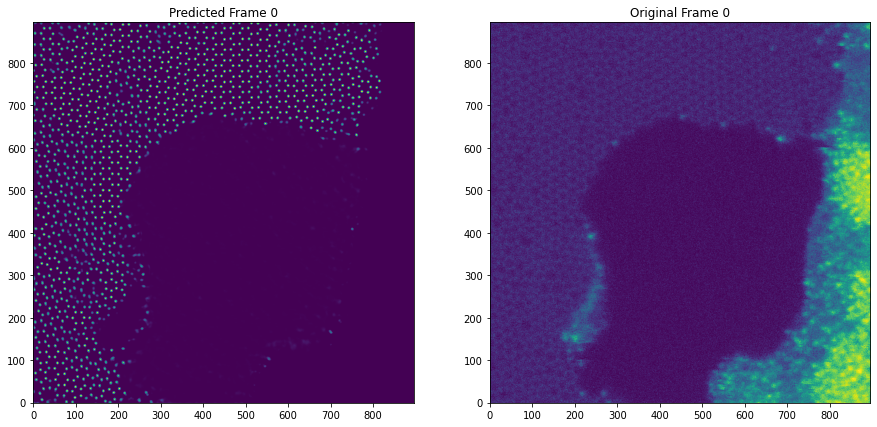

In [38]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.imshow(decoded_imgs_all[99,...,0], origin="lower")
ax1.set_title('Predicted Frame 0')
ax2.imshow(imgdata[99,...], origin="lower")
ax2.set_title('Original Frame 0')